In [1]:
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os
import pickle
import pandas as pd
from sklearn.utils import resample

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [2]:
def get_pickles(split_type): 
    x_train = pickle.load(open(f'../Pickles/{split_type}_x_train.p', 'rb'))
    x_test = pickle.load(open(f'../Pickles/{split_type}_x_test.p', 'rb'))
    y_train = pickle.load(open(f'../Pickles/{split_type}_y_train.p', 'rb'))
    y_test = pickle.load(open(f'../Pickles/{split_type}_y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = get_pickles(3)
print(x_train.shape, x_test.shape) 
print(y_train.shape, y_test.shape)

(2661, 5000) (887, 5000)
(2661,) (887,)


### Resampling
- 0 = negative
- 1 = Positive 
- 2 = neutral

In [3]:
print('Original Train Value Counts')
print(y_train.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Original Test Value Counts')
print(y_test.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


train_df = pd.DataFrame(x_train)
train_df['target'] = y_train.values 

neg_df = train_df[train_df.target == 0]
neut_df = train_df[train_df.target == 1]
pos_df = train_df[train_df.target == 2]



resample_pos = resample(pos_df, n_samples = 500, random_state = 10, replace = True)
resample_neut = resample(neut_df, n_samples = 500, random_state = 10, replace = True)

final_df= neg_df.append(resample_pos, ignore_index = True)
final_df = final_df.append(resample_neut, ignore_index = True)
print('Final Resampled Value Counts')
print(final_df.target.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


x_train_new = final_df[[i for i in final_df.columns if i != 'target']].values
y_train_new = final_df[['target']].values.ravel()

Original Train Value Counts
1.0    2233
0.0     428
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original Test Value Counts
1.0    745
0.0    142
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


ValueError: low >= high

In [7]:
models = {'DT': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
           'LinearSVC': LinearSVC(max_iter = 1250), 'SDGSVC': SGDClassifier(),  
          'ADA': AdaBoostClassifier(), 'Bagging': BaggingClassifier(), 'Ridge': RidgeClassifier(), 
          'RF': RandomForestClassifier()}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
    scores = cross_val_score(m, x_train_new, y_train_new, scoring = 'accuracy', cv = cv, n_jobs = 12, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:43<00:00, 94.35s/it]


In [8]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('models/VanillaResults.p', 'wb'))

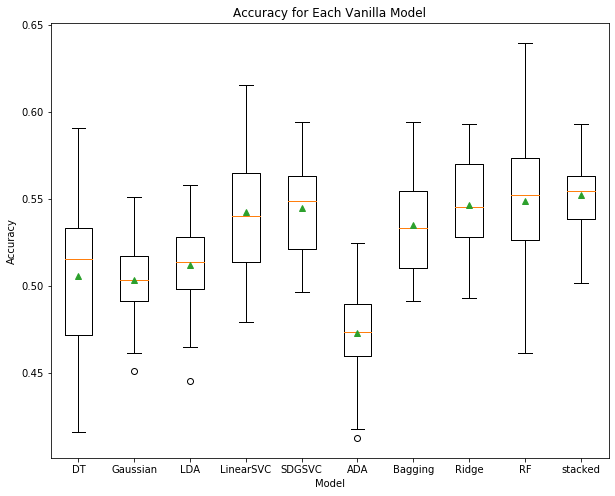

In [9]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (Version 1)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()

In [10]:
models = {'LinearSVC': LinearSVC(max_iter = 1250), 'SDGSVC': SGDClassifier(),  
          'Bagging': BaggingClassifier(), 'Ridge': RidgeClassifier(), 
          'RF': RandomForestClassifier()}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
    scores = cross_val_score(m, x_train_new, y_train_new, scoring = 'accuracy', cv = cv, n_jobs = 12, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:11<00:00, 41.91s/it]


In [11]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('models/VanillaResults2.p', 'wb'))

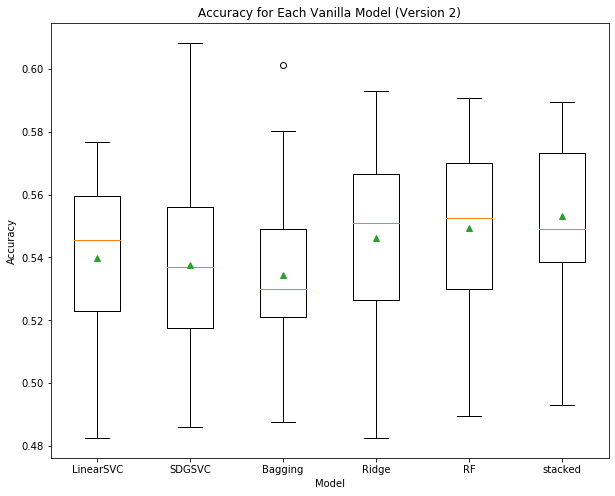

In [12]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (Version 2)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy2.png')
plt.show()

In [ ]:
assert False

### Neural Network

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Embedding, LSTM
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

### Bagging

In [13]:
def get_nn_model(x):
    
    
    model = Sequential()
    model.add(Embedding(5000, 100, input_length = len(x[0]), trainable = False))
    model.add(Flatten())
#     model.add(Dense(512, activation = 'relu', input_shape = x[0].shape))
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dense(512, activation = 'relu'))


    model.add(Dense(3, activation = 'softmax', name = 'OutputLayer'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model



In [14]:
model = get_nn_model(x_train_new)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5000, 100)         500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 500000)            0         
_________________________________________________________________
OutputLayer (Dense)          (None, 3)                 1500003   
Total params: 2,000,003
Trainable params: 1,500,003
Non-trainable params: 500,000
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5)
model_checkpoint = ModelCheckpoint('models/NN-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')

callbacks = [early_stopping, model_checkpoint]
epochs = 100 
batch_size= 32

model_history = model.fit(x_train_new, y_train_new, epochs = epochs, batch_size = batch_size, 
                         validation_data = (x_test, y_test), callbacks = callbacks)

Train on 1428 samples, validate on 2234 samples
Epoch 1/100
1428/1428 [==============================] - 241s 169ms/step - loss: 2.5591 - acc: 0.3312 - val_loss: 0.8996 - val_acc: 0.6030

Epoch 00001: val_loss improved from inf to 0.89964, saving model to models/NN-ModelCheckpointWeights.h5
Epoch 2/100
 896/1428 [=================>............] - ETA: 33s - loss: 1.2830 - acc: 0.3080

(5000,)


      0     1     2     3     4     5     6     7     8     9     10    11    \
0        0     0     0     0     0     0     0     0     0     0     0     0   
1        0     0     0     0     0     0     0     0     0     0     0     0   
2        0     0     0     0     0     0     0     0     0     0     0     0   
3        0     0     0     0     0     0     0     0     0     0     0     0   
4        0     0     0     0     0     0     0     0     0     0     0     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1423     0     0     0     0     0     0     0     0     0     0     0     0   
1424     0     0     0     0     0     0     0     0     0     0     0     0   
1425     0     0     0     0     0     0     0     0     0     0     0     0   
1426     0     0     0     0     0     0     0     0     0     0     0     0   
1427     0     0     0     0     0     0     0     0     0     0     0     0   

      12    13    14    15    16    17 